# Waste Water
Tracking viral load in waste water is leading indicator of coming Covid cases. New Orleans has been slow to start waste water testing, but there is now enough days of data for some analysis.

In [151]:
#import necessary modules
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [152]:
def Is_Enough(df):
    """Takes a df and returns if there is enough data to plot"""
    end_dates = df.date_end.tolist()
    start_dates = df.date_start.tolist()
    first_day = str(np.array(start_dates).min()).split(' ')[0]
    enough = False
    for dat in end_dates:
        if dat in start_dates:
            enough = True
    return enough

In [153]:
#get data
url = 'https://data.cdc.gov/resource/2ew6-ywp6.json?county_names=Orleans'
data = requests.get(url)
df = pd.read_json(data.content)
df.head()

,wwtp_jurisdiction,wwtp_id,reporting_jurisdiction,sample_location,key_plot_id,county_names,county_fips,population_served,date_start,date_end,ptc_15d,detect_prop_15d
0,Louisiana,727,Louisiana,Treatment plant,CDC_la_727_Treatment plant_raw wastewater,Orleans,22071,380000,2022-02-11,2022-02-25,-89.0,100.0
1,Louisiana,727,Louisiana,Treatment plant,CDC_la_727_Treatment plant_raw wastewater,Orleans,22071,380000,2022-02-08,2022-02-22,-91.0,100.0
2,Louisiana,792,Louisiana,Treatment plant,CDC_la_792_Treatment plant_raw wastewater,Orleans,22071,380000,2022-03-03,2022-03-17,-87.0,60.0
3,Louisiana,792,Louisiana,Treatment plant,CDC_la_792_Treatment plant_raw wastewater,Orleans,22071,380000,2022-01-28,2022-02-11,NaN,NaN
4,Louisiana,727,Louisiana,Treatment plant,CDC_la_727_Treatment plant_raw wastewater,Orleans,22071,380000,2022-02-04,2022-02-18,NaN,100.0


In [154]:
#condition dataframe
df = df[['wwtp_id', 'county_names',  'date_start', 'date_end', 'ptc_15d']]
df = df[~df.ptc_15d.isna()]
df.date_start = pd.to_datetime(df.date_start, format='%Y-%m-%d')
df.date_end = pd.to_datetime(df.date_end, format='%Y-%m-%d')
df.sort_values('date_end', inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)

In [155]:
#create dictionary of plants
plants = list(set(df.wwtp_id.tolist()))
plant_dict = {}
for plant in plants:
    plant_dict[plant] = df[df.wwtp_id == plant]

    wwtp_id county_names date_start   date_end  ptc_15d
0       792      Orleans 2022-02-10 2022-02-24     -7.0
1       792      Orleans 2022-02-11 2022-02-25     -7.0
2       792      Orleans 2022-02-12 2022-02-26     -7.0
3       792      Orleans 2022-02-13 2022-02-27     -7.0
4       792      Orleans 2022-02-14 2022-02-28     -7.0
5       792      Orleans 2022-02-15 2022-03-01     -7.0
6       792      Orleans 2022-02-16 2022-03-02   -100.0
7       792      Orleans 2022-02-17 2022-03-03    -96.0
8       792      Orleans 2022-02-18 2022-03-04    -96.0
9       792      Orleans 2022-02-19 2022-03-05    -96.0
10      792      Orleans 2022-02-20 2022-03-06    -96.0
11      792      Orleans 2022-02-21 2022-03-07    -96.0
12      792      Orleans 2022-02-22 2022-03-08    -87.0
13      792      Orleans 2022-02-23 2022-03-09    -84.0
14      792      Orleans 2022-02-24 2022-03-10    -44.0
15      792      Orleans 2022-02-25 2022-03-11    809.0
16      792      Orleans 2022-02-26 2022-03-12  

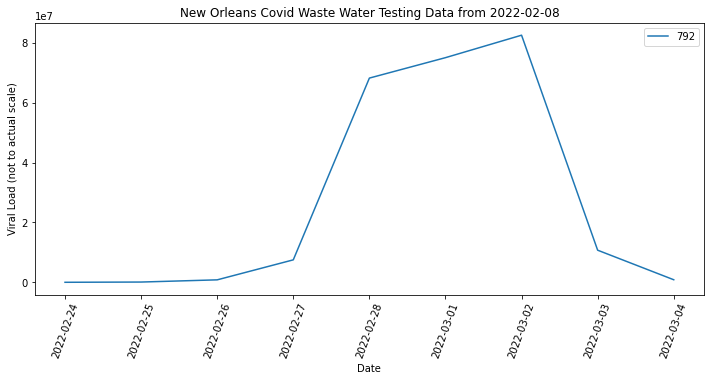

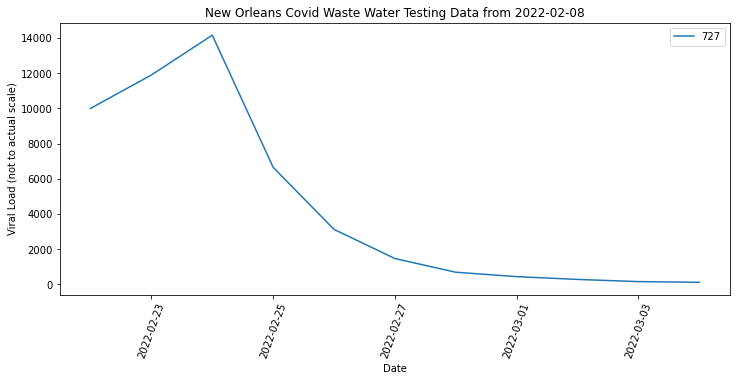

In [159]:
# for each plant, analyze data and produce a graph
for plant in plant_dict:
    dfa = plant_dict.get(plant)
    dfa.reset_index(drop=True, inplace=True)
    dfb=dfa.copy()
    print(dfa)

    #is there enough data to move forward?
    enough = Is_Enough(dfa)
    if not enough:
        print(f'There is not enough data from plant{plant} to analyze.')
        break

    # calculate quantity for first end date forward as start
    idx_first = dfa[dfa.date_start == dfa.date_end.min()].index[0]
    for i in range(idx_first, dfa.index.max()+1, 1):
        if i == idx_first:
            dfb.loc[i, 'start_quantity'] = 10000
        else:
            base = dfb.loc[i-1, 'start_quantity']
            percent_change = dfa.loc[i, 'ptc_15d']
            if percent_change == -100:
                percent_change = -99
            delta = percent_change/100*base
            new_total = base+delta
            dfb.loc[i, 'start_quantity'] = int(new_total)

    # infer old values
#     to_calculate = dfa[~dfa.start_quantity.isna()].date_start.tolist()
#     print(dfa)
#     for dat in to_calculate:
#         calc_idx = dfa[dfa.date_end == dat].index[0]
#         base_idx = dfa[dfa.date_start == dat].index[0]
#         change_factor = dfa.loc[calc_idx, 'ptc_15d']
#         if change_factor == -100:
#             change_factor = -99
#         base = dfa.loc[base_idx, 'start_quantity']
#         start_amt = base/(1+(change_factor/100))
#         dfa.loc[calc_idx, 'start_quantity'] = start_amt
    
    # create figure
    fig = plt.figure(figsize=(12, 5))
    X = dfb.date_start.tolist()
    Y = dfb.start_quantity.tolist()
    plt.plot(X, Y,label=plant)
    plt.title(f'New Orleans Covid Waste Water Testing Data from {first_day}')
    plt.xlabel('Date')
    plt.ylabel('Viral Load (not to actual scale)')
    plt.legend()
    plt.xticks(rotation=70)
